# Preprocessing

In [586]:
import pandas as pd
import numpy as np
import re
import datetime
from os.path import exists
from geopy.geocoders import Nominatim
import folium
import json
import requests
import nltk
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
import pprint
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import PlaintextCorpusReader
from nltk import sent_tokenize,word_tokenize 
from itertools import chain
import matplotlib.pyplot as plt
from random import shuffle
import statsmodels.formula.api as smf
from statsmodels.api import datasets
import seaborn as sns
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adrie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Now that the data has been scraped, we can take the data from all the cities we scraped and put them all together into one single dataframe.

In [587]:
places_raw = pd.read_excel('places.xlsx', header=None)
places = places_raw[0].values

index=0
cities_scraped = []
for city in places:
    if city not in cities_scraped:
        if exists('data_craigslist'+str(city)+'.csv'):
            cities_scraped.append(city)
            if index == 0:
                df = pd.read_csv('data_craigslist'+str(city)+'.csv').drop(columns=['Unnamed: 0'])
                index += 1
            else:
                df = pd.concat([df, pd.read_csv('data_craigslist'+str(city)+'.csv').drop(columns=['Unnamed: 0'])], axis=0, ignore_index=True)

In [588]:
# Gets rid of the rows where we don't have any features
new_index = []
for ind in df.index:
    try:
        if df.loc[ind].count() >= 7:
            new_index.append(ind)
    except:
        pass

df = df.loc[new_index].reset_index(drop=True)

In [589]:
df.columns

Index(['Price', 'Location', 'URL', 'Date', 'Title', 'num image', 'text',
       'condition', 'make / manufacturer', 'model name / number',
       'bicycle frame material', 'bicycle type', 'brake type',
       'electric assist', 'frame size', 'handlebar type', 'suspension',
       'wheel size', 'size / dimensions', 'serial number', 'part type',
       'paint color', 'year manufactured', 'engine hours (total)',
       'length overall (LOA)', 'propulsion type'],
      dtype='object')

In [590]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6659 entries, 0 to 6658
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Price                   6659 non-null   float64
 1   Location                6659 non-null   object 
 2   URL                     6659 non-null   object 
 3   Date                    6659 non-null   object 
 4   Title                   6659 non-null   object 
 5   num image               6659 non-null   int64  
 6   text                    6659 non-null   object 
 7   condition               3078 non-null   object 
 8   make / manufacturer     2677 non-null   object 
 9   model name / number     1902 non-null   object 
 10  bicycle frame material  2644 non-null   object 
 11  bicycle type            2644 non-null   object 
 12  brake type              970 non-null    object 
 13  electric assist         682 non-null    object 
 14  frame size              2503 non-null   

## Cleaning

Let's now go through every column and standardize the features. Because users fill these features by hand, they can type-in many different answers and we have to make sure they all stay consistent.

In [591]:
print(df['bicycle frame material'].unique())

[nan ' aluminum' ' alloy' ' other/unknown' ' steel' ' carbon fiber'
 ' titanium' ' composite' ' scandium']


In [592]:
def fix_bfm(x):
    if pd.isna(x) or x.strip() == 'other/unknown':
        return 'unknown'
    else:
        return x.strip()

df['bicycle frame material'] = df['bicycle frame material'].apply(fix_bfm)

In [593]:
print(df['bicycle frame material'].unique())

['unknown' 'aluminum' 'alloy' 'steel' 'carbon fiber' 'titanium'
 'composite' 'scandium']


In [594]:
df['bicycle type'].unique()

array([nan, ' mountain', ' other', ' kids', ' hybrid/comfort', ' cruiser',
       ' bmx', ' road', ' unicycle', ' folding', ' gravel',
       ' recumbent/trike', ' cyclocross', ' tandem', ' cargo/pedicab',
       ' track'], dtype=object)

In [595]:
def fix_bt(x):
    if pd.isna(x) or x.strip() == 'other':
        return 'unknown'
    else:
        return x.strip()

df['bicycle type'] = df['bicycle type'].apply(fix_bt)

In [596]:
df['bicycle type'].unique()

array(['unknown', 'mountain', 'kids', 'hybrid/comfort', 'cruiser', 'bmx',
       'road', 'unicycle', 'folding', 'gravel', 'recumbent/trike',
       'cyclocross', 'tandem', 'cargo/pedicab', 'track'], dtype=object)

In [597]:
df['frame size'].unique()

array([nan, ' Medium', ' Large', ' 26 inch', ' Fits most bikes!',
       ' 12” wheels', ' 18', ' 0', ' 8"', ' 24”', ' All', ' 26" and 24"',
       ' medium', ' 19.5', ' any', ' 56cm', ' 54 cm, medium', ' 60cm',
       ' All sizes', ' 16 inch', ' unknown', ' N/A', ' Unknown', ' None',
       ' 15 inch', ' 60 cm', ' 18 "', ' 19in', ' 26 in',
       ' 42x40x10 inches', ' 52 cm', ' Any size', ' 15"', ' 18.5”',
       ' n/a', ' Kids size', ' 50cm', " Women's Medium", ' 20" wheels',
       ' 26in.', ' Medium/Large', ' small', ' Small', " don't reall know",
       ' 54cm medium17.5', ' Adult', ' good size', ' MEDIUM TO LARGE',
       ' 27"', ' 20"', ' XXL', ' 65cm', ' 18.25 in (46.35 cm)', ' 20',
       ' child size', ' 49 to 63 cm', ' 26”', ' 16', ' 26"', " 26'",
       ' 16”, 12”', ' About 16 inches.', ' ?', ' 24"', ' .', ' 26',
       ' 17 inch, 25 inch, etc.', ' 17.5 in  54 in',
       ' Standard Cruiser Size', ' kids', ' see pictures',
       ' 19inches 49cm', ' Heavy-duty 57 cm.', ' 20”

In [598]:
def fix_fs(x):
    if pd.isna(x):
        return 'unknown'
    numbers = re.findall(r'\d+', x)
    if len(numbers) == 0:
        if 'medium' in x.lower():
            return 2
        elif 'large' in x.lower():
            return 3
        elif 'small' in x.lower():
            return 1
        else:
            return 'unknown'
    else:
        if '"' or "'" or 'inches' or 'inch' or 'in' in x.lower(): #it's in inches
            size = float(numbers[0]) # assume it's the first number
            if size < 16:
                return 1
            if size > 19:
                return 3
            else:
                return 2
        else: #cm
            size = float(numbers[0])
            if size < 53:
                return 1
            if size > 56:
                return 3
            else:
                return 2

df['frame size'] = df['frame size'].apply(fix_fs)

In [599]:
df['frame size'].unique()

array(['unknown', 2, 3, 1], dtype=object)

In [600]:
df['suspension'].unique()

array([nan, ' suspension fork (hardtail)', ' none (rigid)',
       ' other/unknown', ' frame and fork (full suspension)'],
      dtype=object)

In [601]:
def fix_s(x):
    if pd.isna(x):
        return 0
    if 'fork' in x.lower():
        return 1
    else:
        return 0

df['suspension'] = df['suspension'].apply(fix_s)

In [602]:
df['suspension'].unique()

array([0, 1], dtype=int64)

In [603]:
df['wheel size'].unique()

array([nan, ' 26 in', ' other/unknown', ' 12 in', ' 24 in', ' 20 in',
       ' 27 in', ' 700C', ' 25 in', ' 29 in', ' 14 in', ' 16 in',
       ' 10 in', ' 650B', ' 18 in', ' 27.5 in', ' 28 in', ' 26.5 in',
       ' 650C'], dtype=object)

In [604]:
def fix_ws(x):
    if pd.isna(x):
        return 'unknown'
    if '700' in x.strip():
        return 29
    if '650' in x.strip():
        return 26
    numbers = re.findall(r'\d+', x)
    if len(numbers)==0:
        return 'unknown'
    else:
        if int(numbers[0]) > 30:
            return 'unknown'
        else:
            return int(numbers[0])

df['wheel size'] = df['wheel size'].apply(fix_ws)

In [605]:
df['wheel size'].unique()

array(['unknown', 26, 12, 24, 20, 27, 29, 25, 14, 16, 10, 18, 28],
      dtype=object)

In [606]:
df['condition'].unique()

array([nan, ' excellent', ' new', ' good', ' salvage', ' like new',
       ' fair'], dtype=object)

In [607]:
def fix_c(x):
    if pd.isna(x):
        return 'unknown'
    x = str(x)
    if 'good' in x:
        return 3
    if 'fair' in x:
        return 2
    if 'salvage' in x or 'poor' in x:
        return 1
    if 'new' or 'excellent' in x:
        return 4
    
    return 'unknown'


df['condition'] = df['condition'].apply(fix_c)

In [608]:
df['condition'].unique()

array(['unknown', 4, 3, 1, 2], dtype=object)

In [609]:
df['electric assist'].unique()

array([nan, ' none', ' other', ' throttle', ' pedal assist'], dtype=object)

In [610]:
def fix_ea(x):
    if pd.isna(x):
        return 0
    x = str(x)
    if 'other' in x or 'none' in x:
        return 0
    return 1

df['electric assist'] = df['electric assist'].apply(fix_ea)

In [611]:
df['electric assist'].unique()

array([0, 1], dtype=int64)

In [612]:
df['make / manufacturer'].unique()

array([nan, ' Thule', ' BodyKore', ' Trek', ' Huffy', ' Diamondback',
       ' joystar', ' critical', ' huffy', ' SE Bikes', ' Saris',
       ' Royce Union, Huffy', ' Kent', ' Real tree', ' Cyberbike',
       ' all makes', ' NS Bikes', ' Fuji', ' Allen', ' Schwinn', ' Sun',
       ' Marin', ' Sole', ' Specialized', ' Life Fitness, Cybex, Hammer',
       ' Yakima', ' HUSQVARNA', ' Gatormade Trailers', ' roadmaster',
       ' Orbea', ' Bikemate', ' Suzuki', ' Viathon', ' Harley Davidson',
       ' Tony Hawk', ' Scott', ' Stamina', ' central bike', ' Litespeed',
       ' Jamis', ' mongoose', ' Rollfast', ' Giant', ' Windsor',
       ' Coleman', ' Rad Power Bikes', ' Maxxhaul', ' Dynacraft',
       ' grabber', ' Sears, JC Higgins', ' Salsa', ' Rad Power Bike',
       ' BMX', ' Hollywood', ' Triton', ' CUB CADET', ' BASS CAT',
       ' hotwheels', ' Charge Bikes', ' Free Spirit', ' All', ' Gibson',
       ' Bjorn', ' Lamar Trailers', ' Yamaha', ' sixthreezero',
       ' Rock Solid Cargo', '

In [613]:
def fix_mm(x):
    if pd.isna(x) or 'unknown' in x.lower():
        return 0
    return 1

df['make / manufacturer'] = df['make / manufacturer'].apply(fix_mm)

In [614]:
df['make / manufacturer'].unique()

array([0, 1], dtype=int64)

In [615]:
df['model name / number'].unique()

array([nan, ' 961XT Speedway', ' G703', ..., ' Mix', ' Various/mix',
       ' DRT 1.0'], dtype=object)

In [616]:
def fix_mn(x):
    if pd.isna(x) or 'unknown' in x.lower():
        return 0
    return 1

df['model name / number'] = df['model name / number'].apply(fix_mn)

In [617]:
df['model name / number'].unique()

array([0, 1], dtype=int64)

In [618]:
df['brake type'].unique()

array([nan, ' cantilever', ' disc (mechanical)', ' caliper', ' none',
       ' other/unknown', ' coaster', ' disc (hydraulic)', ' gyro/bmx',
       ' u-brakes', ' v-brakes', ' drum', ' hydraulic rim brakes'],
      dtype=object)

In [619]:
def fix_bt(x):
    if pd.isna(x) or 'other/unknown' in x.lower() or 'none' in x.lower():
        return 'unknown'
    else:
        x = str(x)
        if 'hydraulic' in x:
            return 'hydraulic'
        elif 'mechanical' in x:
            return 'mechanical'
        else:
            return 'special'

df['brake type'] = df['brake type'].apply(fix_bt)

In [620]:
df['brake type'].unique()

array(['unknown', 'special', 'mechanical', 'hydraulic'], dtype=object)

In [621]:
df['handlebar type'].unique()

array([nan, ' flat', ' bmx', ' other/unknown', ' drop', ' cruiser',
       ' triathlon', ' riser', ' downhill', ' aero', ' bullhorn'],
      dtype=object)

In [622]:
def fix_ht(x):
    if pd.isna(x) or 'other/unknown' in x:
        return 'unknown'
    else:
        return 'special'

df['handlebar type'] = df['handlebar type'].apply(fix_ht)

In [623]:
df['handlebar type'].unique()

array(['unknown', 'special'], dtype=object)

In [624]:
df['part type'].unique()

array([nan, ' other', ' racks, fenders, bags', ' saddle',
       ' grips, bar ends, tape', ' tires', ' wheels and wheel parts',
       ' crankset, bottom bracket, guards', ' frameset (frame and fork)',
       ' brakes', ' lights, computers, accessories', ' pedals', ' hubs',
       ' headset, stem, spacers', ' frame only'], dtype=object)

In [625]:
def fix_pt(x):
    if pd.isna(x) or 'other' in x.lower():
        return 0
    else:
        return 1

df['part type'] = df['part type'].apply(fix_pt)
# Let's get rid of the listings about parts
df = df.where(df['part type']==0).dropna(how='all').drop(columns=['part type'])

In [626]:
df['size / dimensions'].unique()

array([nan, ' 1 1/4” hitch', ' 26.38 x 12.2 x 13.98',
       ' \u200e42 x 40 x 10 inches', ' 750', ' 56x9.5x4.5',
       ' 4-bike capacity', ' 168" X 86" X 0"', ' 192" X 84" X 0"',
       ' 168" X 83" X 0"', ' 26”', ' 2011---2016', ' 51x 48x30',
       ' 36 Volt 42 Volt 48 Volt', ' S, L, M, XL, XXL', ' See above',
       ' 5\'×17" UNFOLDED', ' 31.5 x 21 x 25.5 in (Interior)',
       ' 125cc 250cc 500cc', ' 8.5 x 28', " Women's size medium", ' 1111',
       ' Large', ' 22', ' na', ' 196cc', ' 9 x 22', ' 7.48 mm',
       ' 2500 sq feet', ' 6 feet', ' 12x5', ' 42', ' 59x32x42in',
       ' 7.5 feet tall approx', ' 5x1x3,12', " Men's Large",
       ' Fully Inspected', ' 41" x 20"', ' X-Large', ' 62"wide',
       ' 7X14X3 16K GN DUMP TRAILER', ' 25 LBS', ' 40’x 7’8”x 79”tall',
       ' 32" x 68" x 74"', ' 20”', ' 3x4', ' 600', ' Holds 4 Bikes', ' ?',
       ' 130/90-16', ' 16 x 5.00', ' 240" X 82" X 0"', ' 144" X 76" X 0"',
       ' 240" X 102" X 0"', ' 432" X 102" X 0"', ' 240" X 83" X 0"',

In [627]:
def fix_sd(x):
    if pd.isna(x):
        return 0
    else:
        return 1

df['size / dimensions'] = df['size / dimensions'].apply(fix_sd)

In [628]:
df['size / dimensions'].unique()

array([0, 1], dtype=int64)

In [629]:
df['paint color'].unique()

array([nan, ' black', ' grey', ' custom', ' white', ' silver', ' brown',
       ' red'], dtype=object)

In [630]:
def fix_pc(x):
    if pd.isna(x):
        return 0
    else:
        return 1

df['paint color'] = df['paint color'].apply(fix_pc)

In [631]:
df['paint color'].unique()

array([0, 1], dtype=int64)

In [632]:
df['serial number'].unique()

array([nan, ' Unknown', ' F1068892', ' N/A', ' EN14872XINGING',
       ' TC19 222501', ' na', ' NSN not needed', ' Model GS32401', ' 000',
       ' 20A16575', ' M5060820', ' RU1F20V0502', ' yes', ' GS62660',
       ' un', ' EB720DO', ' S  / N', ' on request', ' none',
       ' AITPZ29SD6L1G1', ' SNHU07J15066', ' #185', ' F7U42856',
       ' LF201110072', ' ?', ' 01V120067', ' E6EE07509', ' Assorted',
       ' WSBC025068284R', ' 170720', ' 26’', ' M50', ' UUK19C01204', 1.0,
       ' EZ-201304 468', ' 56750N514', ' H92010532', ' PA20301', ' N/n',
       ' 00020002', ' FZ18GY0047', ' Not sure', ' many', ' unknown',
       ' 408 406 7864 cell', ' Var', ' 1960', ' bb1655', ' KAEK23231',
       ' 03v1210616', ' 69', ' C53FR342/ C45EL435', ' WN6L06970',
       ' 1265830', ' U86K02008/ C167-K', ' Nome', ' 23-918',
       ' See Photos', ' EG010897', ' 00012345', ' .', ' various',
       ' Ninja 2021', ' Freestyle', ' ??', ' NA', ' WT0406C5218',
       ' WTU336CT0109R1207', ' N/a', ' 1234567890'

In [633]:
def fix_sn(x):
    if pd.isna(x):
        return 0
    elif isinstance(x, float):
        return 1
    else:
        if 'unknown' in x.lower() or 'no' in x.lower() or 'n/' in x.lower():
            return 0
    return 1

df['serial number'] = df['serial number'].apply(fix_sn)

In [634]:
df['serial number'].unique()

array([0, 1], dtype=int64)

In [635]:
df['year manufactured'].unique()

array([  nan, 2022., 2020., 2010., 1975., 2018., 2015., 1979., 2005.,
       2021., 2013., 1987., 1990., 2006., 2004., 2000., 2001., 2019.,
       2012., 2017.])

In [636]:
def fix_ym(x):
    if pd.isna(x):
        return 0
    else:
        return 1

df['year manufactured']=df['year manufactured'].apply(fix_ym)

In [637]:
df['year manufactured'].unique()

array([0, 1], dtype=int64)

In [638]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6544 entries, 0 to 6658
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Price                   6544 non-null   float64
 1   Location                6544 non-null   object 
 2   URL                     6544 non-null   object 
 3   Date                    6544 non-null   object 
 4   Title                   6544 non-null   object 
 5   num image               6544 non-null   float64
 6   text                    6544 non-null   object 
 7   condition               6544 non-null   object 
 8   make / manufacturer     6544 non-null   float64
 9   model name / number     6544 non-null   float64
 10  bicycle frame material  6544 non-null   object 
 11  bicycle type            6544 non-null   object 
 12  brake type              6544 non-null   object 
 13  electric assist         6544 non-null   float64
 14  frame size              6544 non-null   

In [639]:
df.columns

Index(['Price', 'Location', 'URL', 'Date', 'Title', 'num image', 'text',
       'condition', 'make / manufacturer', 'model name / number',
       'bicycle frame material', 'bicycle type', 'brake type',
       'electric assist', 'frame size', 'handlebar type', 'suspension',
       'wheel size', 'size / dimensions', 'serial number', 'paint color',
       'year manufactured', 'engine hours (total)', 'length overall (LOA)',
       'propulsion type'],
      dtype='object')

In [640]:
# These 3 columns have less than 0.1% of data available so we'll drop them
df = df.drop(columns=['length overall (LOA)', 'propulsion type', 'engine hours (total)'])

In [641]:
df.columns = [column.replace('/', '').lower().strip().replace(' ', '') for column in df.columns]

In [642]:
df.columns

Index(['price', 'location', 'url', 'date', 'title', 'numimage', 'text',
       'condition', 'makemanufacturer', 'modelnamenumber',
       'bicycleframematerial', 'bicycletype', 'braketype', 'electricassist',
       'framesize', 'handlebartype', 'suspension', 'wheelsize',
       'sizedimensions', 'serialnumber', 'paintcolor', 'yearmanufactured'],
      dtype='object')

Let's add the number of days since the listing was posted on the website as a feature.

In [643]:
df['days'] = [(datetime.datetime.today()-datetime.datetime.strptime(date_, "%Y-%m-%d %H:%M")).days for date_ in df['date']]

# Missing values analysis

How many of each features are we missing, and can we find these values within the text (body of the listing)?

In [644]:
important_attributes = ['price', 'condition', 'numimage', 'bicycleframematerial', 'bicycletype', 'braketype', 'framesize', 'handlebartype','wheelsize']

for column in important_attributes:
    df_values = pd.DataFrame(df.groupby([column]).size())
    display(df_values)

,0
price,
1.0,270
2.0,2
4.0,2
5.0,24
7.0,3
...,...
445522.0,1
595000.0,1
999992.0,1


,0
condition,
1,20
2,113
3,682
4,2159
unknown,3570


,0
numimage,
0.0,1161
2.0,725
3.0,617
4.0,599
5.0,473
6.0,440
7.0,384
8.0,259
9.0,231


,0
bicycleframematerial,
alloy,247
aluminum,900
carbon fiber,131
composite,17
scandium,1
steel,704
titanium,16
unknown,4528


,0
bicycletype,
bmx,280
cargo/pedicab,8
cruiser,273
cyclocross,11
folding,58
gravel,45
hybrid/comfort,197
kids,319
mountain,622


,0
braketype,
hydraulic,261
mechanical,140
special,448
unknown,5695


,0
framesize,
1,297
2,632
3,928
unknown,4687


,0
handlebartype,
special,594
unknown,5950


,0
wheelsize,
10,35
12,69
14,38
16,110
18,53
20,326
24,154
25,21
26,647


In [645]:
def loss_analysis(df):
    unknown_dic = dict()
    n=len(df)
    for column in important_attributes:
        df_values = pd.DataFrame(df.groupby([column]).size())
        if column == 'price':
            unknown = len(df[(df['price']<10) | (df['price']>300)])
            unknown_dic[column]=[unknown,round(unknown/n*100,1)]
        try:
            unknown = int(df_values.loc['unknown'])
        except:
            pass
        else:
            unknown_dic[column]=[unknown,round(unknown/n*100,1)]
    df_unknown = pd.DataFrame(data=unknown_dic,index=['Unknowns','% of Unknowns']).transpose()
    return df_unknown

In [646]:
loss_analysis(df)

,Unknowns,% of Unknowns
price,3600.0,55.0
condition,3570.0,54.6
bicycleframematerial,4528.0,69.2
bicycletype,4345.0,66.4
braketype,5695.0,87.0
framesize,4687.0,71.6
handlebartype,5950.0,90.9
wheelsize,4489.0,68.6


## Let's look into the text

In [647]:
def retrieve_condition_from_txt(text):
    sentences = re.compile(r'([A-Z][^\.!?]*[\.!?])', re.M).findall(text)
    for sentence in sentences:
        if 'condition' in sentence:
            return sentence

def fix_condition_from_txt(text,condition):
    if condition != 'unknown':
        return condition
    else:
        sentence = retrieve_condition_from_txt(text)
        if sentence is None:
            return 'unknown'
        else:
            sentence = sentence.lower()
            if 'very good' in sentence or 'excellent' in sentence or 'new' in sentence or 'very nice' in sentence:
                return str(4)
            if 'good used condition' in sentence or 'good' in sentence or 'very pretty' in sentence or 'great' in sentence:
                return str(3)
            if 'nice' in sentence or 'fair' in sentence:
                return str(2)
            if 'poor' in sentence or 'salvage' in sentence:
                return str(1)
            else:
                return 'unknown'

before = loss_analysis(df).loc['condition','Unknowns']
df['condition'] = df.apply(lambda x: fix_condition_from_txt(x['text'],x['condition']), axis=1)
after = loss_analysis(df).loc['condition','Unknowns']
print("+ "+ str(int(before-after)) + " data for 'condition' after using fix_condition_from_txt.")


+ 411 data for 'condition' after using fix_condition_from_txt.


In [648]:
def fix_material_from_txt(text, material):
    if material != 'unknown':
        return material
    else:
        if 'aluminum' in text:
            return 'aluminum'
        if 'alloy' in text:
            return 'alloy'
        if 'steel' in text:
            return 'steel'
        if 'carbon' in text:
            return 'carbon fiber'
        if 'titanium' in text:
            return 'titanium'
        if 'composite' in text:
            return 'composite'
        if 'scandium' in text:
            return 'scandium'
        else:
            return 'unknown'


before = loss_analysis(df).loc['bicycleframematerial','Unknowns']
df['bicycleframematerial'] = df.apply(lambda x: fix_material_from_txt(x['text'],x['bicycleframematerial']), axis=1)
after = loss_analysis(df).loc['bicycleframematerial','Unknowns']
print("+ "+ str(int(before-after)) + " data for 'bicycleframematerial' after using fix_material_from_txt.")

+ 612 data for 'bicycleframematerial' after using fix_material_from_txt.


In [649]:
def fix_bicycletype_from_txt(text,bicycletype):
    if bicycletype != 'unknown':
        return bicycletype
    else:
        if 'mountain' in text:
            return 'mountain'
        if 'kids' in text:
            return 'kids'
        if 'hybrid' in text:
            return 'hybrid/comfort'
        if 'comfort' in text:
            return 'hybrid/comfort'
        if 'cruiser' in text:
            return 'cruiser'
        if 'bmx' in text:
            return 'bmx'
        if 'road' in text:
            return 'road'
        if 'unicycle' in text:
            return 'unicycle'
        if 'folding' in text:
            return 'folding'
        if 'gravel' in text:
            return 'gravel'
        if 'recumbent' in text:
            return 'recumbent/trike'
        if 'cyclocross' in text:
            return 'cyclocross'
        if 'tandem' in text:
            return 'tandem'
        if 'track' in text:
            return 'track'
        if 'cargo' in text:
            return 'cargo/pedicab'
        if 'pedicab' in text:
            return 'cargo/pedicab'
        else:
            return 'unknown'

before = loss_analysis(df).loc['bicycletype','Unknowns']
df['bicycletype'] = df.apply(lambda x: fix_bicycletype_from_txt(x['text'],x['bicycletype']), axis=1)
after = loss_analysis(df).loc['bicycletype','Unknowns']
print("+ "+ str(int(before-after)) + " data for 'bicycletype' after using fix_bicycletype_from_txt.")

+ 1456 data for 'bicycletype' after using fix_bicycletype_from_txt.


In [650]:
def fix_braketype_from_txt(text,braketype):
    if braketype != 'unknown':
        return braketype
    else:
        if 'mechanical' in text:
            return 'mechanical'
        if 'hydraulic' in text:
            return 'hydraulic'
        else:
            return 'unknown'

before = loss_analysis(df).loc['braketype','Unknowns']
df['braketype'] = df.apply(lambda x: fix_braketype_from_txt(x['text'],x['braketype']), axis=1)
after = loss_analysis(df).loc['braketype','Unknowns']
print("+ "+ str(int(before-after)) + " data for 'braketype' after using fix_braketype_from_txt.")

+ 184 data for 'braketype' after using fix_braketype_from_txt.


In [651]:
loss_analysis(df)

,Unknowns,% of Unknowns
price,3600.0,55.0
condition,3159.0,48.3
bicycleframematerial,3916.0,59.8
bicycletype,2889.0,44.1
braketype,5511.0,84.2
framesize,4687.0,71.6
handlebartype,5950.0,90.9
wheelsize,4489.0,68.6


# Price preprocessing

It happens pretty often that people set unrealistic prices, of $1 for example. Sometimes, people don't sell bikes too, they sell motorcycles, which are much more extensive. The goal of this part is to get rid of these listings, and if possible, to retrieve the real price from the text.

In [652]:
df.price.describe()

count    6.544000e+03
mean     1.614774e+04
std      8.231906e+05
min      1.000000e+00
25%      8.000000e+01
50%      3.250000e+02
75%      2.799000e+03
max      6.543290e+07
Name: price, dtype: float64

The standard deviation is extremely high, let's look carefully into the listings with a price greater than $3000 or smaller than $10.

In [653]:
df_filter = df[(df['price']>3000) | (df['price']<10)]
print(f'The number of incoherent announces regarding their price is: ',len(df_filter))

The number of incoherent announces regarding their price is:  1867


For example, you can see below the discrepancy between the listed price and the one we can find in the text:

For one listing we have:

- Price: $ 1.0
- Description:  SCHWINN CLASSIC BIKES, SELLING AS A PAIR. ONLY $100 FOR BOTH!

In [654]:
index_list = df_filter.index
index_list_final = list()
new_price_list = list()

for i in df.index:
  if i in df_filter.index:
    new_price_int = list()
    try:
      new_price = re.findall('\$(\x20?\d+(?:[,]\d{0,3})?)', df_filter['text'][i])
      for j in new_price:
        new_price_int.append(int(j.replace(',','')))
      if new_price_int == []:
        new_price = float('Nan')
        new_price_list.append(new_price)
        index_list_final.append(i)
      else:
        new_price_list.append(int(sum(new_price_int)/len(new_price_int)))
        index_list_final.append(i)
    except:
      #If there is no match, we replace the price value by NaN to eliminate them easily from our database
      new_price_list.append(float('Nan'))
      index_list_final.append(i)
  else:
    new_price_list.append(df['price'][i])
    index_list_final.append(i)

df_new_price = pd.DataFrame({'price' : new_price_list, 'Index':index_list_final})
df_new_price.set_index('Index', inplace = True)
df_new_price.head()

,price
Index,
0,1000.0
1,NaN
2,2995.0
3,30.0
4,112.0


Let's add back the new prices we found:

In [655]:
df['price'] = df_new_price['price']

In [656]:
df.price.describe()

count      5655.000000
mean       2169.986737
std        8291.981603
min           0.000000
25%          80.000000
50%         275.000000
75%        1449.000000
max      317422.000000
Name: price, dtype: float64

In [657]:
df = df[(df['price']<=3000) & (df['price']>=10)]

In [658]:
df.price.describe()

count    4995.000000
mean      582.252252
std       760.812018
min        10.000000
25%        75.000000
50%       200.000000
75%       800.000000
max      3000.000000
Name: price, dtype: float64

We can see above that the standard deviation is now much smaller, and that the values seem more realistic for bikes.

# Let us get rid of the non-bikes listings by finding topics within text

In [659]:
#We will use the description and the title of the annouce to get the topic

df_info = df[['text','title']]

bike_desc_list = list()
for i in df_info.index:
    bike_desc_list.append(df_info['title'][i]+df_info['text'][i])

for i in range(len(bike_desc_list)):
    desc = bike_desc_list[i]
    sents = sent_tokenize(desc)
    for j in range(len(sents)):
        sent = sents[j]
        sent = sent.strip().replace('\n','')
        sents[j] = sent
    bike_desc_list[i] = '. '.join(sents)

texts = [[word for word in desc.lower().split()
        if word not in STOPWORDS and word.isalpha() and not word.lower() == 'slate'] #We only keep alpha values
        for desc in bike_desc_list]

dictionary = corpora.Dictionary(texts) #(word_id,word) pairs
corpus = [dictionary.doc2bow(text) for text in texts] #(word_id,freq) pairs by sentence

In [660]:
#Set parameters
num_topics = 3 #The number of topics that should be generated
passes = 25

lda = LdaModel(corpus,
              id2word=dictionary,
              num_topics=num_topics,
              passes=passes)

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(lda.print_topics(num_words=8))

[   (   0,
        '0.130*"trailers" + 0.076*"motorcycle" + 0.052*"camping" + 0.047*"car" '
        '+ 0.041*"trailer" + 0.031*"dolly" + 0.029*"sale" + 0.026*"atv"'),
    (   1,
        '0.027*"bike" + 0.019*"bikes" + 0.012*"new" + 0.007*"will" + '
        '0.006*"rack" + 0.005*"frame" + 0.005*"mountain" + 0.005*"equipment"'),
    (   2,
        '0.015*"dirt" + 0.010*"inch" + 0.009*"road" + 0.007*"go" + '
        '0.007*"custom" + 0.006*"new" + 0.006*"call" + 0.006*"honda"')]


In [661]:
lda_corpus = lda[corpus]

# Find the threshold, let's set the threshold to be 1/#clusters,
# To prove that the threshold is sane, we average the sum of all probabilities:
scores = list(chain(*[[score for topic_id,score in topic] \
                      for topic in [doc for doc in lda_corpus]]))
threshold = sum(scores)/len(scores)
print(threshold)
index_cluster1=[]
index_cluster2=[]
index_cluster3=[]
counter = -1
for i,j in zip(lda_corpus,bike_desc_list):
    counter+=1
    for size in range(len(i)):
        if i[size][1] > threshold:
            if i[size][0] == 0:
                index_cluster1.append(counter)
            elif i[size][0] == 1:
                index_cluster2.append(counter)
            elif i[size][0] == 2:
                index_cluster3.append(counter)

0.4159597245362448


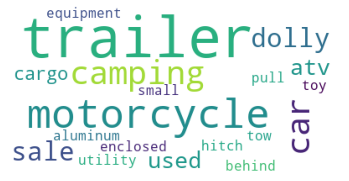

In [662]:
#We create word clouds to know which cluster corresponds to which topics

def draw_wordcloud(lda,topicnum,min_size=0,STOPWORDS=[]):
    word_list=[]
    prob_total = 0
    for word,prob in lda.show_topic(topicnum,topn=50):
        prob_total +=prob
    for word,prob in lda.show_topic(topicnum,topn=50):
        if word in STOPWORDS or  len(word) < min_size:
            continue
        freq = int(prob/prob_total*100)
        alist=[word]
        word_list.extend(alist*freq)
        
    %matplotlib inline
    shuffle(word_list)
    text = ' '.join(word_list)
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',max_words=20).generate(text)

    plt.axis('off')
    plt.imshow(wordcloud)

    return word_list

word_list_1 = draw_wordcloud(lda,0)

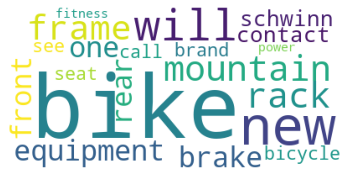

In [663]:
word_list_2 = draw_wordcloud(lda,1)

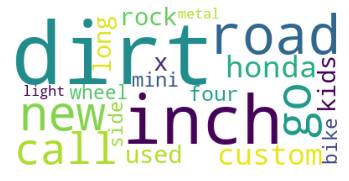

In [664]:
word_list_3 = draw_wordcloud(lda,2)

In [665]:
def count_bike(list_words):
    count=0
    for word in list_words:
        if word == 'bike' or word == 'bikes':
            count+=1
    return count

In [666]:
word_lists = [word_list_1, word_list_2, word_list_3]

index_not_bikes = []
for i, words in enumerate(word_lists):
    if count_bike(words) < 3:
        if i == 0:
            index_not_bikes += index_cluster1
        elif i == 1:
            index_not_bikes += index_cluster2
        elif i == 2:
            index_not_bikes += index_cluster3

print(f'We are getting rid of {len(index_not_bikes)} rows.')
print(f'Cluster 1 has {len(index_cluster1)} rows.')
print(f'Cluster 2 has {len(index_cluster2)} rows.')
print(f'Cluster 3 has {len(index_cluster3)} rows.')

We are getting rid of 703 rows.
Cluster 1 has 120 rows.
Cluster 2 has 4435 rows.
Cluster 3 has 583 rows.


In [667]:
# We delete the annouces which do not correspond to bike annouces for sure
df = df.reset_index(drop=True)

for i in index_not_bikes:
    df.drop(index=i, inplace = True, errors='ignore')
df.reset_index(inplace = True)
df.drop(columns = 'index', inplace= True)

In [668]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4292 entries, 0 to 4291
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 4292 non-null   float64
 1   location              4292 non-null   object 
 2   url                   4292 non-null   object 
 3   date                  4292 non-null   object 
 4   title                 4292 non-null   object 
 5   numimage              4292 non-null   float64
 6   text                  4292 non-null   object 
 7   condition             4292 non-null   object 
 8   makemanufacturer      4292 non-null   float64
 9   modelnamenumber       4292 non-null   float64
 10  bicycleframematerial  4292 non-null   object 
 11  bicycletype           4292 non-null   object 
 12  braketype             4292 non-null   object 
 13  electricassist        4292 non-null   float64
 14  framesize             4292 non-null   object 
 15  handlebartype        

# Analysis and visualization

Let's visualize the average price per state.

In [669]:
def preprocess_cities(cities):
    for i, city in enumerate(cities):
        if city == 'newyork':
            cities[i] = 'new york'
        elif city == 'newjersey':
            cities[i] = 'new jersey'
        elif city == 'lasvegas':
            cities[i] = 'las vegas'
        elif city == 'longisland':
            cities[i] = 'long island'
        elif city == 'losangeles':
            cities[i] = 'los angeles'
        elif city == 'saltlakecity':
            cities[i] = 'salt lake city'
        elif city == 'sfbay':
            cities[i] = 'san francisco'
    return cities

def preprocess_back_cities(cities):
    for i, city in enumerate(cities):
        if city == 'new york':
            cities[i] = 'newyork'
        elif city == 'new jersey':
            cities[i] = 'newjersey'
        elif city == 'las vegas':
            cities[i] = 'lasvegas'
        elif city == 'long island':
            cities[i] = 'longisland'
        elif city == 'los angeles':
            cities[i] = 'losangeles'
        elif city == 'salt lake city':
            cities[i] = 'saltlakecity'
        elif city == 'san francisco':
            cities[i] = 'sfbay'
    return cities

all_cities = preprocess_cities(df['location'].unique())

In [670]:
states= ['Alabama', 'Alaska', 'Arizona', 'Arkansas','California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois'
,'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri'
,'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma'
,'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

codes = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE'
,'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']

state_codes = {}
for i, state in enumerate(states):
    state_codes[state] = codes[i]

In [671]:
def find_states(all_cities):
    """Takes a list of cities and returns a dictionary of the cities and their corresponding state."""
    geolocator = Nominatim(user_agent="location script")
    
    dict_states = {}
    
    for city in all_cities:

        location = str(geolocator.geocode(city))
        for state in states:
            if state.lower() in location.lower():
                dict_states[city] = state_codes[state]
        
    return dict_states #finally retruns the dict 

city_states = find_states(all_cities)

states_cities = {}
for key in city_states:
    if city_states[key] not in states_cities:
        states_cities[city_states[key]] = [key]
    else:
        states_cities[city_states[key]].append(key)

In [672]:
def find_mean_price_per_state(state_cities_dict):

    price_per_state = {}

    for state in state_cities_dict:

        price_per_state[state] = []

        list_of_cities_not_ready = state_cities_dict[state]
        list_of_cities = preprocess_back_cities(list_of_cities_not_ready)

        for city in list_of_cities:
            price_per_state[state].append(df.where(df['location']==city).dropna()['price'].mean())

        price_per_state[state] = np.mean(price_per_state[state])
    
    return price_per_state

mean_price_data = pd.DataFrame.from_dict(find_mean_price_per_state(states_cities), 'index', columns=['mean price']).reset_index().rename(columns={'index':'state'})
mean_price_data.head()

,state,mean price
0,AL,362.395531
1,IN,410.696970
2,AK,515.945949
3,AZ,642.460063
4,NM,629.529412


In [673]:
us_states_url_indata = {}
data_url = ("https://raw.githubusercontent.com/python-visualization/folium/master/examples/data")
us_states_url = f"{data_url}/us-states.json"
t = requests.get(us_states_url).content
geodict = json.loads(t)
us_states_url_indata['type'] = geodict['type']
us_states_url_indata['features'] = []
for state_dic in geodict['features']:
    if state_dic['id'] in mean_price_data['state'].values:
        us_states_url_indata['features'].append(state_dic)

In [674]:
m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=us_states_url_indata,
    name='choropleth',
    data=mean_price_data,
    columns=['state', 'mean price'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Mean price'
).add_to(m)

m

# Feature Selection

## Explainability: Benjamini Hochberg procedure & p-values

In [675]:
important_attributes = ['numimage','condition', 'bicycleframematerial', 'bicycletype','braketype',
                        'electricassist', 'framesize', 'handlebartype','suspension','wheelsize','sizedimensions']

corr_important_attributes = ['numimage','condition', 'bicycleframematerial', 'bicycletype','braketype',
                        'C(electricassist)', 'framesize', 'handlebartype','C(suspension)','wheelsize','C(sizedimensions)']

In [676]:
df = df[['price'] + important_attributes]

In [677]:
df.dtypes

price                   float64
numimage                float64
condition                object
bicycleframematerial     object
bicycletype              object
braketype                object
electricassist          float64
framesize                object
handlebartype            object
suspension              float64
wheelsize                object
sizedimensions            int64
dtype: object

In [678]:
df['condition'] = df['condition'].replace(to_replace='unknown', value=np.nan).astype(float)
df['electricassist'] = df['electricassist'].astype(int)
df['framesize'] = df['framesize'].replace(to_replace='unknown', value=np.nan).astype(float)
df['suspension'] = df['suspension'].astype(int)
df['wheelsize'] = df['wheelsize'].replace(to_replace='unknown', value=np.nan).astype(float)

In [679]:
candidates = []

y = 'price'

while(len(candidates)<len(df.columns)-1):
    p_values = dict()
    for x in df.drop([y] + candidates, axis=1).columns:
        if len(candidates) == 0:
            features = x
        else:
            if df.dtypes[x]==int:
                features = 'C('+ x + ')' + ' + '
            else: 
                features = x + ' + '
            features += ' + '.join(candidates)
        model = smf.ols(y + ' ~ ' + features, df).fit()
        p_values[x] = model.summary2().tables[1]['P>|t|'][1:].mean()
    
    min_p_key = min(p_values, key=p_values.get)
    min_p = min(p_values.values())

    if min_p <= 0.05:
        candidates.append(min_p_key)
    else:
        break

candidates

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\ProgramData\Anaconda3\lib\site-packages\statsmo

['electricassist',
 'numimage',
 'braketype',
 'condition',
 'suspension',
 'wheelsize',
 'sizedimensions',
 'handlebartype']

In [680]:
def categorical_attributes(candidates):
    output = list()
    for candidate in candidates:
        if candidate == 'electricassist' or candidate == 'sizedimensions' or candidate =='suspension':
            output.append('C(' + candidate + ')')
        else:
            output.append(candidate)
    return output

corr_candidates = categorical_attributes(candidates)
corr_candidates

['C(electricassist)',
 'numimage',
 'braketype',
 'condition',
 'C(suspension)',
 'wheelsize',
 'C(sizedimensions)',
 'handlebartype']

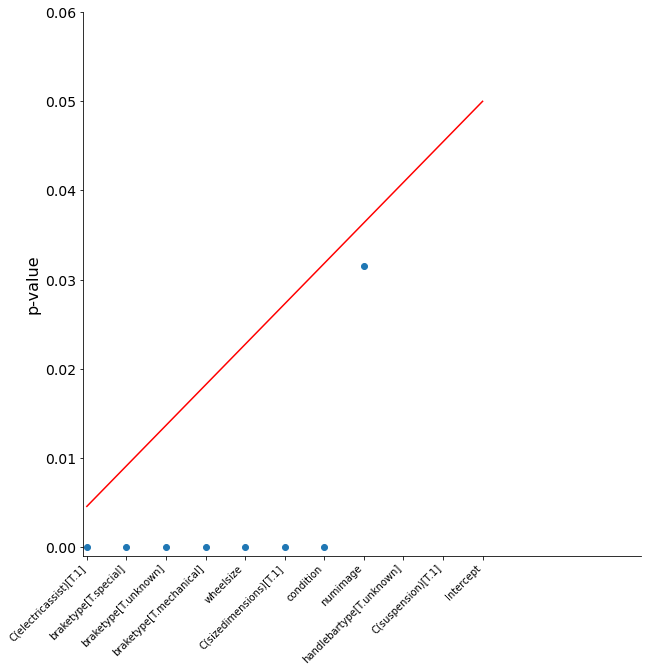

In [681]:
final_model = smf.ols(' price ~ + ' + ' + '.join(corr_candidates), data=df).fit()
df_p_values = final_model.summary2().tables[1].sort_values('P>|t|', ascending = True)
#df_p_values = df_p_values[df_p_values['P>|t|']<0.05]
n_vars = len(df_p_values)

plt.figure(figsize=(10, 10))

plt.plot(range(1, n_vars+1), df_p_values['P>|t|'], linewidth=0, marker='o')
plt.plot(range(1, n_vars+1), [0.05*i/n_vars for i in range(1, n_vars+1)], color='red')

plt.ylim([-0.001, 0.06])
plt.xlim([0.9, 15])

plt.xticks(ticks=range(1, n_vars+1), labels=df_p_values.index, rotation=45, ha='right')
plt.yticks(fontsize=14)

plt.ylabel('p-value', fontsize=16)

sns.despine()

In [682]:
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     118.1
Date:                Wed, 27 Apr 2022   Prob (F-statistic):          8.09e-160
Time:                        14:12:28   Log-Likelihood:                -9589.1
No. Observations:                1247   AIC:                         1.920e+04
Df Residuals:                    1237   BIC:                         1.925e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -7.8837    145.419     -0.054      0.957    -293.178     277.411
C(electricassist)[T.1]     792.3047     54.334     14.582      0.000     685.708     898.902
braketype[T.mechanical]   -566.8739     65.474     -8.658      0.000    -695.327    -438.421
braketype[T.special]      -778.5960     56.027    -13.897      0.000    -888.514    -668.678
braketype[T.unknown]      -671.6789     58.709    -11.441      0.000    -786.859    -556.498
C(suspension)[T.1]         -65.7049     39.541     -1.662      0.097    -143.281      11.871
C(sizedimensions)[T.1]    2.205e-13   3.33e-14      6.625      0.000    1.55e-13    2.86e-13
handlebartype[T.unknown]   -67.8510     40.378     -1.680      0.093    -147.068      11.366
numimage                     6.0470      2.809      2.153      0.032       0.537      11.557
condition                  134.6022     27.258      4.938      0.000      81.125     188.079
wheelsize                   27.2970      3.454      7.902      0.000      20.520      34.074
==============================================================================
Omnibus:                      543.847   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2659.356
Skew:                           2.028   Prob(JB):                         0.00
Kurtosis:                       8.894   Cond. No.                     1.02e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is  8e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [683]:
final_model.summary2().tables[1].sort_values('P>|t|').round(3)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
C(electricassist)[T.1],792.305,54.334,14.582,0.000,685.708,898.902
braketype[T.special],-778.596,56.027,-13.897,0.000,-888.514,-668.678
braketype[T.unknown],-671.679,58.709,-11.441,0.000,-786.859,-556.498
braketype[T.mechanical],-566.874,65.474,-8.658,0.000,-695.327,-438.421
wheelsize,27.297,3.454,7.902,0.000,20.520,34.074
C(sizedimensions)[T.1],0.000,0.000,6.625,0.000,0.000,0.000
condition,134.602,27.258,4.938,0.000,81.125,188.079
numimage,6.047,2.809,2.153,0.032,0.537,11.557
handlebartype[T.unknown],-67.851,40.378,-1.680,0.093,-147.068,11.366
C(suspension)[T.1],-65.705,39.541,-1.662,0.097,-143.281,11.871


In [684]:
all_var_model = smf.ols(' price ~ + ' + ' + '.join(corr_important_attributes), data=df).fit()
all_var_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     36.37
Date:                Wed, 27 Apr 2022   Prob (F-statistic):          1.27e-137
Time:                        14:12:29   Log-Likelihood:                -7803.1
No. Observations:                1024   AIC:                         1.567e+04
Df Residuals:                     993   BIC:                         1.582e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                              238.5457    184.860      1.290      0.197    -124.215     601.306
bicycleframematerial[T.aluminum]       -53.3853     52.454     -1.018      0.309    -156.319      49.549
bicycleframematerial[T.carbon fiber]   771.0171     91.213      8.453      0.000     592.025     950.009
bicycleframematerial[T.composite]     -184.8629    198.453     -0.932      0.352    -574.298     204.573
bicycleframematerial[T.scandium]     -2.381e-12   1.91e-12     -1.250      0.212   -6.12e-12    1.36e-12
bicycleframematerial[T.steel]          -87.8503     56.713     -1.549      0.122    -199.140      23.440
bicycleframematerial[T.titanium]       -51.3905    198.763     -0.259      0.796    -441.434     338.653
bicycleframematerial[T.unknown]        -81.7798     71.491     -1.144      0.253    -222.070      58.510
bicycletype[T.cargo/pedicab]          1027.0804    508.757      2.019      0.044      28.719    2025.442
bicycletype[T.cruiser]                 -99.8368     72.968     -1.368      0.172    -243.025      43.352
bicycletype[T.cyclocross]              585.3457    189.448      3.090      0.002     213.581     957.111
bicycletype[T.folding]                 135.3628    115.246      1.175      0.240     -90.792     361.517
bicycletype[T.gravel]                   77.3625    122.703      0.630      0.529    -163.424     318.149
bicycletype[T.hybrid/comfort]         -121.6845     76.770     -1.585      0.113    -272.335      28.966
bicycletype[T.kids]                   -178.9240     73.903     -2.421      0.016    -323.947     -33.901
bicycletype[T.mountain]                -70.7275     70.751     -1.000      0.318    -209.566      68.112
bicycletype[T.recumbent/trike]         724.0976    213.188      3.397      0.001     305.746    1142.449
bicycletype[T.road]                     -4.5213     72.495     -0.062      0.950    -146.782     137.739
bicycletype[T.tandem]                  438.6270    296.438      1.480      0.139    -143.089    1020.343
bicycletype[T.track]                    77.4598    188.697      0.410      0.682    -292.831     447.751
bicycletype[T.unicycle]                135.3058    262.899      0.515      0.607    -380.595     651.207
bicycletype[T.unknown]                 170.4653     90.688      1.880      0.060      -7.496     348.427
braketype[T.mechanical]               -516.2762     70.684     -7.304      0.000    -654.983    -377.570
braketype[T.special]                  -696.4630     61.696    -11.289      0.000    -817.532    -575.394
braketype[T.unknown]                  -574.0244     64.816     -8.856      0.000    -701.217    -446.832
C(electricassist)[T.1]                 791.8206     62.029     12.765      0.000     670.097     913.544
handlebartype[T.unknown]              

In [685]:
all_var_model.summary2().tables[1].sort_values('P>|t|').round(3)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
C(electricassist)[T.1],791.821,62.029,12.765,0.000,670.097,913.544
braketype[T.special],-696.463,61.696,-11.289,0.000,-817.532,-575.394
braketype[T.unknown],-574.024,64.816,-8.856,0.000,-701.217,-446.832
bicycleframematerial[T.carbon fiber],771.017,91.213,8.453,0.000,592.025,950.009
braketype[T.mechanical],-516.276,70.684,-7.304,0.000,-654.983,-377.570
condition,103.929,29.297,3.547,0.000,46.437,161.420
bicycletype[T.recumbent/trike],724.098,213.188,3.397,0.001,305.746,1142.449
wheelsize,18.453,5.704,3.235,0.001,7.260,29.647
bicycletype[T.cyclocross],585.346,189.448,3.090,0.002,213.581,957.111
bicycletype[T.kids],-178.924,73.903,-2.421,0.016,-323.947,-33.901


## Feature selection for prediction: Adjusted R²

In [686]:
#Let's first use our step-wise forward selection regression

candidates = []
last_max = -1

y = 'price'

while(True):
    dict_r2 = dict()
    for x in df.drop([y] + candidates, axis=1).columns:
        if len(candidates) == 0:
            features = x
        else:
            if df.dtypes[x]==int:
                features = 'C('+ x + ')' + ' + '
            else: 
                features = x + ' + '
            features += ' + '.join(candidates)

        model = smf.ols(y + ' ~ ' + features, df).fit()
        dict_r2[x] = 1-((1-model.rsquared)*(len(df)-1)/(len(df)-len(candidates)-1-1))

    max_dict_r2 =  max(dict_r2.values())
    max_dict_r2_key = max(dict_r2, key=dict_r2.get)

    if max_dict_r2 > last_max:
        candidates.append(max_dict_r2_key)
        last_max = max_dict_r2

        print('Added features: ', candidates )
        print('Adjusted R2: ' + str(max_dict_r2))
        print('***')
    else:
        break

print('\n\n')
print('elminated variables: ')
print(set(df.drop(y, axis=1).columns).difference(candidates))

Added features:  ['braketype']
Adjusted R2: 0.23478190449745506
***
Added features:  ['braketype', 'condition']
Adjusted R2: 0.3520608490688104
***
Added features:  ['braketype', 'condition', 'bicycleframematerial']
Adjusted R2: 0.3875808499367813
***
Added features:  ['braketype', 'condition', 'bicycleframematerial', 'electricassist']
Adjusted R2: 0.4240685415837786
***
Added features:  ['braketype', 'condition', 'bicycleframematerial', 'electricassist', 'wheelsize']
Adjusted R2: 0.514350074276843
***
Added features:  ['braketype', 'condition', 'bicycleframematerial', 'electricassist', 'wheelsize', 'bicycletype']
Adjusted R2: 0.5407726417689502
***
Added features:  ['braketype', 'condition', 'bicycleframematerial', 'electricassist', 'wheelsize', 'bicycletype', 'numimage']
Adjusted R2: 0.5427329303926622
***
Added features:  ['braketype', 'condition', 'bicycleframematerial', 'electricassist', 'wheelsize', 'bicycletype', 'numimage', 'handlebartype']
Adjusted R2: 0.5434894100069538
***



In [687]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     51.97
Date:                Wed, 27 Apr 2022   Prob (F-statistic):          1.43e-185
Time:                        14:12:38   Log-Likelihood:                -9485.8
No. Observations:                1247   AIC:                         1.903e+04
Df Residuals:                    1218   BIC:                         1.918e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                              307.4236    162.081      1.897      0.058     -10.565     625.413
braketype[T.mechanical]               -563.6399     62.636     -8.999      0.000    -686.526    -440.754
braketype[T.special]                  -713.8839     55.048    -12.968      0.000    -821.884    -605.884
braketype[T.unknown]                  -592.6568     55.721    -10.636      0.000    -701.976    -483.337
bicycleframematerial[T.aluminum]       -63.3727     47.578     -1.332      0.183    -156.716      29.970
bicycleframematerial[T.carbon fiber]   770.0440     83.953      9.172      0.000     605.336     934.752
bicycleframematerial[T.composite]     -127.7416    183.601     -0.696      0.487    -487.951     232.468
bicycleframematerial[T.scandium]      1.047e-12   9.68e-13      1.081      0.280   -8.53e-13    2.95e-12
bicycleframematerial[T.steel]          -94.4905     51.932     -1.820      0.069    -196.376       7.395
bicycleframematerial[T.titanium]       -54.2901    193.199     -0.281      0.779    -433.330     324.750
bicycleframematerial[T.unknown]       -145.8899     62.909     -2.319      0.021    -269.312     -22.468
bicycletype[T.cargo/pedicab]            65.8299    289.824      0.227      0.820    -502.780     634.440
bicycletype[T.cruiser]                -121.6559     61.554     -1.976      0.048    -242.419      -0.892
bicycletype[T.cyclocross]              528.4191    183.072      2.886      0.004     169.247     887.591
bicycletype[T.folding]                 111.0300     99.296      1.118      0.264     -83.779     305.839
bicycletype[T.gravel]                   56.7347    111.766      0.508      0.612    -162.540     276.010
bicycletype[T.hybrid/comfort]         -168.7507     64.724     -2.607      0.009    -295.734     -41.768
bicycletype[T.kids]                   -233.4953     63.218     -3.693      0.000    -357.524    -109.466
bicycletype[T.mountain]               -148.7195     56.611     -2.627      0.009    -259.785     -37.654
bicycletype[T.recumbent/trike]         395.5160    157.756      2.507      0.012      86.013     705.019
bicycletype[T.road]                    -67.9695     63.198     -1.076      0.282    -191.958      56.019
bicycletype[T.tandem]                  248.9767    225.503      1.104      0.270    -193.440     691.394
bicycletype[T.track]                    13.0702    164.050      0.080      0.937    -308.781     334.922
bicycletype[T.unicycle]                 75.4779    254.656      0.296      0.767    -424.136     575.092
bicycletype[T.unknown]                 115.2792     75.714      1.523      0.128     -33.265     263.824
handlebartype[T.unknown]               -59.1194     38.955     -1.518      0.129    -135.546      17.307
sizedimensions                        

In [688]:
corr_candidates = categorical_attributes(candidates)
corr_candidates

['braketype',
 'condition',
 'bicycleframematerial',
 'C(electricassist)',
 'wheelsize',
 'bicycletype',
 'numimage',
 'handlebartype']

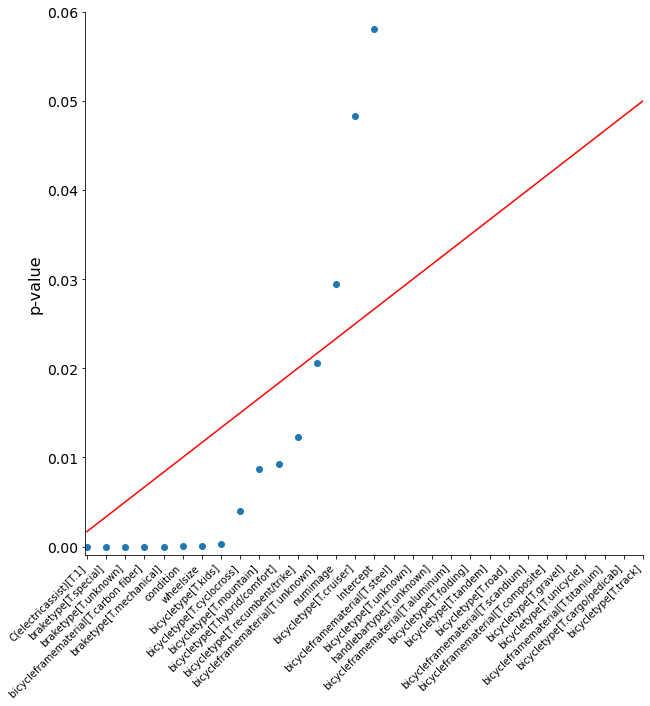

In [689]:
#Let's use the Benjamini Hochberg procedure to keep only significant variables

final_model = smf.ols(' price ~ + ' + ' + '.join(corr_candidates), data=df).fit()
df_p_values = final_model.summary2().tables[1].sort_values('P>|t|', ascending = True)
#df_p_values = df_p_values[df_p_values['P>|t|']<0.05]
n_vars = len(df_p_values)

plt.figure(figsize=(10, 10))

plt.plot(range(1, n_vars+1), df_p_values['P>|t|'], linewidth=0, marker='o')
plt.plot(range(1, n_vars+1), [0.05*i/n_vars for i in range(1, n_vars+1)], color='red')

plt.ylim([-0.001, 0.06])
plt.xlim([0.9, 15])

plt.xticks(ticks=range(1, n_vars+1), labels=df_p_values.index, rotation=45, ha='right')
plt.yticks(fontsize=14)

plt.ylabel('p-value', fontsize=16)

sns.despine()

In [694]:
df_p_values.index[:13]

Index(['C(electricassist)[T.1]', 'braketype[T.special]',
       'braketype[T.unknown]', 'bicycleframematerial[T.carbon fiber]',
       'braketype[T.mechanical]', 'condition', 'wheelsize',
       'bicycletype[T.kids]', 'bicycletype[T.cyclocross]',
       'bicycletype[T.mountain]', 'bicycletype[T.hybrid/comfort]',
       'bicycletype[T.recumbent/trike]', 'bicycleframematerial[T.unknown]'],
      dtype='object')

In [691]:
#Let's compute the adjusted R2 if we continued to add more variables

number_variables = []
R2_list = []
candidates = []
last_max = -1

y = 'price'

while(len(candidates)<len(df.columns)-1):
    dict_r2 = dict()
    for x in df.drop([y] + candidates, axis=1).columns:
        if len(candidates) == 0:
            features = x
        else:
            if df.dtypes[x]==int:
                features = 'C('+ x + ')' + ' + '
            else: 
                features = x + ' + '
            features += ' + '.join(candidates)

        model = smf.ols(y + ' ~ ' + features, df).fit()
        dict_r2[x] = 1-((1-model.rsquared)*(len(df)-1)/(len(df)-len(candidates)-2))

    max_dict_r2 =  max(dict_r2.values())
    max_dict_r2_key = max(dict_r2, key=dict_r2.get)

    if max_dict_r2 > last_max or max_dict_r2 <= last_max:
        candidates.append(max_dict_r2_key)
        last_max = max_dict_r2

        number_variables.append(len(candidates))
        R2_list.append(max_dict_r2)
    else:
        break

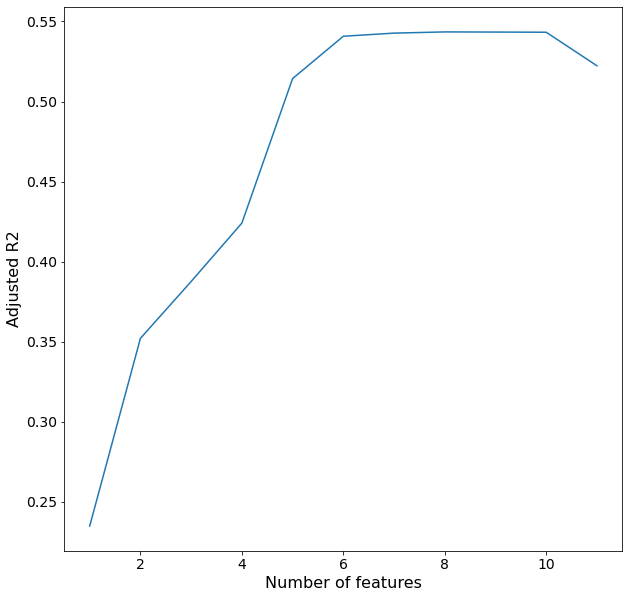

<Figure size 432x288 with 0 Axes>

In [692]:
#Let's plot the evolution of the adjusted R2

plt.figure(figsize=(10, 10))
plt.plot(number_variables, R2_list)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Number of features', fontsize=16)
plt.ylabel('Adjusted R2', fontsize=16)
plt.show()

sns.despine()

In [693]:
df.to_csv('preprocessed_data_craigslist.csv')